In [1]:
#import all the necessary libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn import svm
from sklearn.svm import SVR

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score, max_error, mean_pinball_loss

In [2]:
# days defines the time period for predicting
days = 30

##############Support Vecor Machine##################
gamma = 1e-12
kernel = "rbf"
c = 1e8

######some other declerations and function###########

min_max_scalar = MinMaxScaler()

def metrics(true, predicted, model):
    print("Model: "+model)
    print("Mean Absolute Error: "+str(mean_absolute_error(true, predicted)))
    print("Root Mean Square Error: "+str(np.sqrt(mean_squared_error(true, predicted))))
    print("Explained Variance Score: "+str(explained_variance_score(true, predicted)))
    print("R² Score: "+str(r2_score(true, predicted)))
    print("Max Error Scorer: "+str(max_error(true, predicted))+"\n")
    print("**********************************************************\n")

#### Starting with the last Preparations

This Notebook will start with the results/cleaned dataframe from "StepA_DataPrepartion.ipynb" which is stored in under the Path "./data/daily_dataframe.csv"

In [3]:
df = pd.read_csv("./data/daily_dataframe.csv")

In [4]:
df

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,4.476415,4.478946,4.476415,4.478946,18.296675,81.131884,4.477370
1,4.765486,4.765486,4.765486,4.765486,6.520824,31.728779,4.765486
2,5.000000,5.000000,5.000000,5.000000,15.537153,77.685764,5.000000
3,5.225903,5.225903,5.225903,5.225903,7.633635,39.441143,5.225903
4,5.186993,5.227674,5.186993,5.227674,13.885945,74.060105,5.201707
...,...,...,...,...,...,...,...
3371,55192.143139,55218.473451,55167.740437,55194.338458,1.814064,100341.387345,55192.261999
3372,55834.184958,55858.268208,55811.112208,55835.612028,1.443994,80412.639688,55833.580482
3373,56911.283486,56942.541743,56881.677681,56911.995660,3.724880,213292.698642,56910.369124
3374,58346.922167,58371.047285,58323.091465,58348.516944,2.359691,137978.415411,58346.019783


Last check for NaN values:

In [5]:
df.isnull().sum(axis = 0)

Open                 0
High                 0
Low                  0
Close                0
Volume_(BTC)         0
Volume_(Currency)    0
Weighted_Price       0
dtype: int64

Since the dataset has been already prepared in the first step, the are no NaN values.  
But to get a smaller dataframe I will only work with Weighted_Price, because it fully correlates with OHLC(Open,High,Low and Close) Prices

In [6]:
df = df.drop(['Open','High','Low','Close','Volume_(BTC)','Volume_(Currency)'], axis = 1)
df

,Weighted_Price
0,4.477370
1,4.765486
2,5.000000
3,5.225903
4,5.201707
...,...
3371,55192.261999
3372,55833.580482
3373,56910.369124
3374,58346.019783


In [7]:
#Creating a Scaled Dataframe
df_scaled = min_max_scalar.fit_transform(df)

In [8]:
#Create Column for Prediction and shift it for last x days (Parameter from the beginning)

df['pred'] = df[['Weighted_Price']].shift(-days)

#Converting the Dataframe into an array
X = np.array(df.drop(columns='pred',axis=1))
X = X[:-days]

#print(X)

y = np.array(df['pred'])
# Get all of the y values except the last '30' rows
y = y[:-days]

#setting up a variable "pred" containing the days for prediction
pred = np.array(df.drop(columns='pred',axis=1))[-days:]

In [9]:
# Split the data into training and testing with train_test_split()
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#### Starting with the Models

In [10]:
#Initialising the Model(SVM) and fitting

svm = SVR(kernel=kernel, C=c, gamma=gamma) 
svm.fit(x_train, y_train)

SVR(C=100000000.0, gamma=1e-12)

In [11]:
#Initialising the Model (LR) and fitting
lr = LinearRegression()
# Train the model
lr.fit(x_train, y_train)

LinearRegression()

In [12]:
#Predicting with SVM (SVR)
svm_prediction = svm.predict(pred)
#Predicting with LR
lr_prediction = lr.predict(pred)

In [13]:
print(svm_prediction)

[58537.788432   61137.78483944 59656.06658052 57256.58062741
 58187.97967601 60830.87634757 61674.42219669 66331.83872424
 68398.57030213 69742.51392193 70574.9799518  73551.66830869
 76096.95992628 71607.50838971 68348.82414377 69570.93987347
 73063.45706833 72775.78159674 73529.21357151 71308.24477259
 70517.36560142 67402.12415762 68039.16482641 63600.87070589
 65240.48317825 68129.01495806 69085.90965261 70701.07511917
 72871.11289792 73506.99519794]


#### Evaluation of the Metrics:

I decided to use the following the metrics to evaluate the Model:
  
- Mean Absolute Error (MAE)
- Root Mean Square Error (RMSE)
- Explained Variance Score (EVS)
- R² Score (R2)
- Max Error Score (MES)

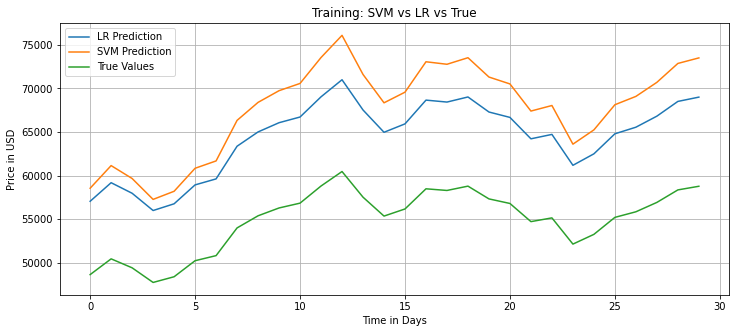

In [14]:
# First Plotting the Training Period with Prediction vs True Values

plt.figure(figsize=(12, 5))
plt.title("Training: SVM vs LR vs True")
plt.xlabel('Time in Days')
plt.ylabel('Price in USD')
plt.grid(visible=True, which='major', axis='both')
plt.plot(lr_prediction, label = 'LR Prediction')
plt.plot(svm_prediction, label = 'SVM Prediction')
plt.plot(pred, label = 'True Values')
plt.legend()
plt.show()

In [15]:
true = pred
svm = svm_prediction
lreg = lr_prediction

# Printing the metrics mentioned above
metrics(true, svm, "SVM, Support Vector Machine")
metrics(true, lreg, "LR, Linear Regression")

Model: SVM, Support Vector Machine
Mean Absolute Error: 12837.906118053257
Root Mean Square Error: 12948.056398256756
Explained Variance Score: 0.7727879843520709
R² Score: -12.411319409308051
Max Error Scorer: 15639.529535113521

**********************************************************

Model: LR, Linear Regression
Mean Absolute Error: 9541.573922091588
Root Mean Square Error: 9562.535032977945
Explained Variance Score: 0.9679665715180238
R² Score: -6.314900441904619
Max Error Scorer: 10541.37351697003

**********************************************************

